# **Regression Project (Store Sales -- Time Series Forecasting)**
## **Corporation Favorita**
## **Sydney Group**

In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpathes
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import datetime as dt
import squarify


from datetime import datetime
from datetime import date

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [4]:
# For CSV, use pandas.read_csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Loading all datasets
holiday = pd.read_csv('/content/drive/MyDrive/lp2/holidays_events.csv',index_col=["date"],parse_dates=["date"])
oil = pd.read_csv('/content/drive/MyDrive/lp2/oil.csv', parse_dates=["date"])
stores = pd.read_csv('/content/drive/MyDrive/lp2/stores.csv')
test = pd.read_csv('/content/drive/MyDrive/lp2/test.csv',index_col=["date"],parse_dates=["date"])
train = pd.read_csv('/content/drive/MyDrive/lp2/train.csv',index_col=["date"],parse_dates=['date'])
transactions = pd.read_csv('/content/drive/MyDrive/lp2/transactions.csv',index_col=["date"],parse_dates=["date"])
sample_submission = pd.read_csv('/content/drive/MyDrive/lp2/sample_submission.csv')

# Exploratory Data Analysis: EDA
## Univariate Analysis and Multivariate Analysis
Dataframes

In [6]:
# Print out the shapes of the datasets
print(f"The shape of the holiday dataset is: {holiday.shape}")
print(f"The shape of the oil dataset is: {oil.shape}")
print(f"The shape of the stores dataset is: {stores.shape}")
print(f"The shape of the test dataset is: {test.shape}")
print(f"The shape of the train dataset is: {train.shape}")
print(f"The shape of the transactions dataset is: {transactions.shape}")
print(f"The shape of the sample_submission dataset is: {sample_submission.shape}")

The shape of the holiday dataset is: (350, 5)
The shape of the oil dataset is: (1218, 2)
The shape of the stores dataset is: (54, 5)
The shape of the test dataset is: (28512, 4)
The shape of the train dataset is: (3000888, 5)
The shape of the transactions dataset is: (83488, 2)
The shape of the sample_submission dataset is: (28512, 2)


In [7]:
# Print the data types of each dataset
def show_data_type(dataset_name, dataset):
    print(f"Data types for {dataset_name}:")
    print(dataset.dtypes)
    print('_' * 50)
        
show_data_type('Stores', stores)
show_data_type('Train', train)
show_data_type('Test', test)
show_data_type('Transactions', transactions)
show_data_type('Oil', oil)
show_data_type('Holiday', holiday)
show_data_type('Sample_Submission', sample_submission)



Data types for Stores:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
__________________________________________________
Data types for Train:
id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
__________________________________________________
Data types for Test:
id              int64
store_nbr       int64
family         object
onpromotion     int64
dtype: object
__________________________________________________
Data types for Transactions:
store_nbr       int64
transactions    int64
dtype: object
__________________________________________________
Data types for Oil:
date          datetime64[ns]
dcoilwtico           float64
dtype: object
__________________________________________________
Data types for Holiday:
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
_______

In [8]:
#checking for the summary of the datasets:
datasets = {'holiday': holiday, 'oil': oil, 'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'sample_submission' : sample_submission}

for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset summary statistics:\n")
    print(data.describe())
    print('_' * 50)


Holiday dataset summary statistics:

           type    locale locale_name description transferred
count       350       350         350         350         350
unique        6         3          24         103           2
top     Holiday  National     Ecuador    Carnaval       False
freq        221       174         174          10         338
__________________________________________________

Oil dataset summary statistics:

        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
__________________________________________________

Stores dataset summary statistics:

       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
__________________________________________________

Trai

In [9]:
# showing missing values in all dataset using a function

datasets = {'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'oil': oil, 'holiday': holiday, 'sample_submission' : sample_submission}

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in {name} dataset:")
        print(data.isnull().sum())
        print('_' * 50)

show_missing_values(datasets)


Missing values in stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
__________________________________________________
Missing values in train dataset:
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
__________________________________________________
Missing values in test dataset:
id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64
__________________________________________________
Missing values in transactions dataset:
store_nbr       0
transactions    0
dtype: int64
__________________________________________________
Missing values in oil dataset:
date           0
dcoilwtico    43
dtype: int64
__________________________________________________
Missing values in holiday dataset:
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
__________________________________________________
Missing values in sample_sub

*   We can see that only the oil dataset have missing values

lets work on that:




In [10]:
#replacing the nan with the mean of each month of its year
for year in range(2013, 2023):
    for month in range(1, 13):
        mask = (oil['date'].dt.month == month) & (oil['date'].dt.year == year)
        mean = oil.loc[mask, 'dcoilwtico'].mean()
        oil.loc[mask, 'dcoilwtico'] = oil.loc[mask, 'dcoilwtico'].fillna(mean)



In [11]:
# Print the missing values in the dataset again to confirm that there are no missing values left
print(oil.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


# **Merging all datasets for further EDA**

In [12]:
# combine the datasets on common columns one after the other
merged_data1 = pd.merge(train, transactions, how='outer', on=['date', 'store_nbr'])
merged_data2 = pd.merge(merged_data1, holiday, how='outer', on='date')
merged_data3 = pd.merge(merged_data2, oil, how='outer', on='date')
merged_data = pd.merge(merged_data3, stores, how='outer', on='store_nbr')

In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054427 entries, 0 to 3054426
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   id            float64       
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   type_x        object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  dcoilwtico    float64       
 13  city          object        
 14  state         object        
 15  type_y        object        
 16  cluster       float64       
dtypes: datetime64[ns](1), float64(7), object(9)
memory usage: 419.5+ MB


we notice some column names like type_x, type_y..lets work on this by renaming them

In [14]:
merged_data = merged_data.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})
merged_data.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0


In [15]:
# Show info of merged_data
print("Info of merged_data:\n")
merged_data.info()
print('_' * 50)

# Show missing values in merged_data
print("\nMissing values in merged_data:\n")
print(merged_data.isna().sum())
print('_' * 50)

# Show shape of merged_data
print("\nShape of merged_data:", merged_data.shape)
print('_' * 50)

# Show describe of merged_data
print("\nDescribe of merged_data:\n")
print(merged_data.describe().T)
print('_' * 50)

# Show duplicated values in merged_data
print("\nDuplicated values in merged_data:", merged_data.duplicated().sum())      


Info of merged_data:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054427 entries, 0 to 3054426
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   id            float64       
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   holiday_type  object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  dcoilwtico    float64       
 13  city          object        
 14  state         object        
 15  store_type    object        
 16  cluster       float64       
dtypes: datetime64[ns](1), float64(7), object(9)
memory usage: 419.5+ MB
__________________________________________________

Missing values in merged_data:

date                  0
id                   79
store_nbr     

In [16]:
merged_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1.504277e+06,866261.012008,0.00,754676.75,1507571.50,2255120.250,3000887.00
store_nbr,3054348.0,2.750000e+01,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,3.590209e+02,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480e+00,12.254939,0.00,0.00,0.00,0.000,741.00
transactions,2805231.0,1.697071e+03,966.831652,5.00,1046.00,1395.00,2081.000,8359.00
dcoilwtico,2175837.0,6.791923e+01,25.672600,26.19,46.53,53.38,95.610,110.62
cluster,3054348.0,8.481481e+00,4.649735,1.00,4.00,8.50,13.000,17.00


# Let us Answer some **Questions**

1. Is the train dataset complete (has all the required dates)?

In [17]:
if train.isnull().sum().sum() == 0:
    print("The train dataset is complete.")
else:
    print("The train dataset is incomplete.")

The train dataset is complete.


In [18]:
# Create a date range from the first date to the last date in the series
date_range = pd.date_range(start=train.index.min(), end=train.index.max())

# Check if there are any dates in the range that are not in the index
missing_dates = date_range.difference(train.index)

if len(missing_dates) == 0:
    print("The time series is complete.")
else:
    print("The time series is not complete. The following dates are missing:")
    print(missing_dates)

The time series is not complete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


2. Which dates have the lowest and highest sales for each year?

In [19]:
merged_data['year'] = pd.to_datetime(merged_data['date']).dt.year

# Group merged_data by year and date
grouped_data = merged_data.groupby(['year', 'date'])

# Calculate total sales for each date
sales_by_date = grouped_data['sales'].sum()

# Sort sales_by_date in ascending and descending order
lowest_sales = sales_by_date.groupby('year').nsmallest(1)
highest_sales = sales_by_date.groupby('year').nlargest(1)

# Print dates with lowest and highest sales for each year
for year in merged_data['year'].unique():
    print("Year:", year)
    print("Lowest sales:", lowest_sales[year])
    print("Highest sales:", highest_sales[year])
    print("-" * 50)


Year: 2013
Lowest sales: year  date      
2013  2013-12-25    0.0
Name: sales, dtype: float64
Highest sales: year  date      
2013  2013-12-22    1.392590e+06
Name: sales, dtype: float64
--------------------------------------------------
Year: 2014
Lowest sales: year  date      
2014  2014-12-25    0.0
Name: sales, dtype: float64
Highest sales: year  date      
2014  2014-12-22    2.016287e+06
Name: sales, dtype: float64
--------------------------------------------------
Year: 2015
Lowest sales: year  date      
2015  2015-12-25    0.0
Name: sales, dtype: float64
Highest sales: year  date      
2015  2015-12-22    2.283724e+06
Name: sales, dtype: float64
--------------------------------------------------
Year: 2016
Lowest sales: year  date      
2016  2016-12-25    0.0
Name: sales, dtype: float64
Highest sales: year  date      
2016  2016-06-25    2.580891e+06
Name: sales, dtype: float64
--------------------------------------------------
Year: 2017
Lowest sales: year  date      
2017  

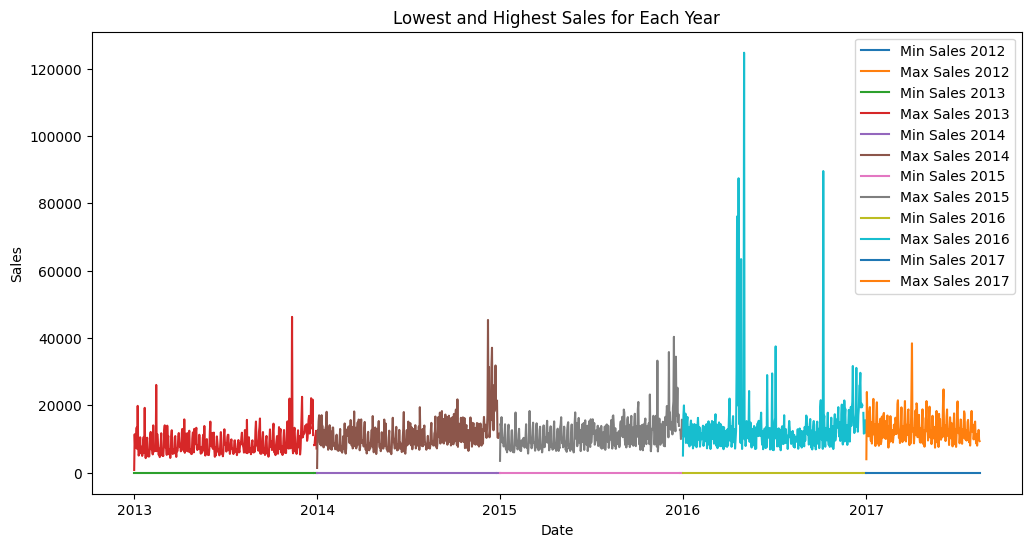

In [20]:
# Group the merged_data by year and date, and calculate the minimum and maximum sales for each date
sales_by_date = merged_data.groupby(['year', 'date'])['sales'].agg(['min', 'max'])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each year, and plot the minimum and maximum sales for each date as two lines
for year in sales_by_date.index.get_level_values('year').unique():
    data = sales_by_date.loc[year]
    ax.plot(data.index.get_level_values('date'), data['min'], label=f'Min Sales {year}')
    ax.plot(data.index.get_level_values('date'), data['max'], label=f'Max Sales {year}')

# Set the title, x-axis label, y-axis label, and legend
ax.set_title('Lowest and Highest Sales for Each Year')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()

# Display the chart
plt.show()

3. Did the earthquake impact sales?

A magnitude 7.8 earthquake struck Ecuador on **April 16, 2016**. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [22]:
# merged_data[merged_data['date'] == '2016-04-16']['sales'].sum()
date = '2016-04-16'
sales_sum = merged_data[merged_data['date'] == date]['sales'].sum()
print("The sales for the date {} is ${:,.2f}".format(date, sales_sum))


The sales for the date 2016-04-16 is $862,121.49


we can see that the sales on day the earthquake happened was $862121, however, we are interested in weeks after the event.

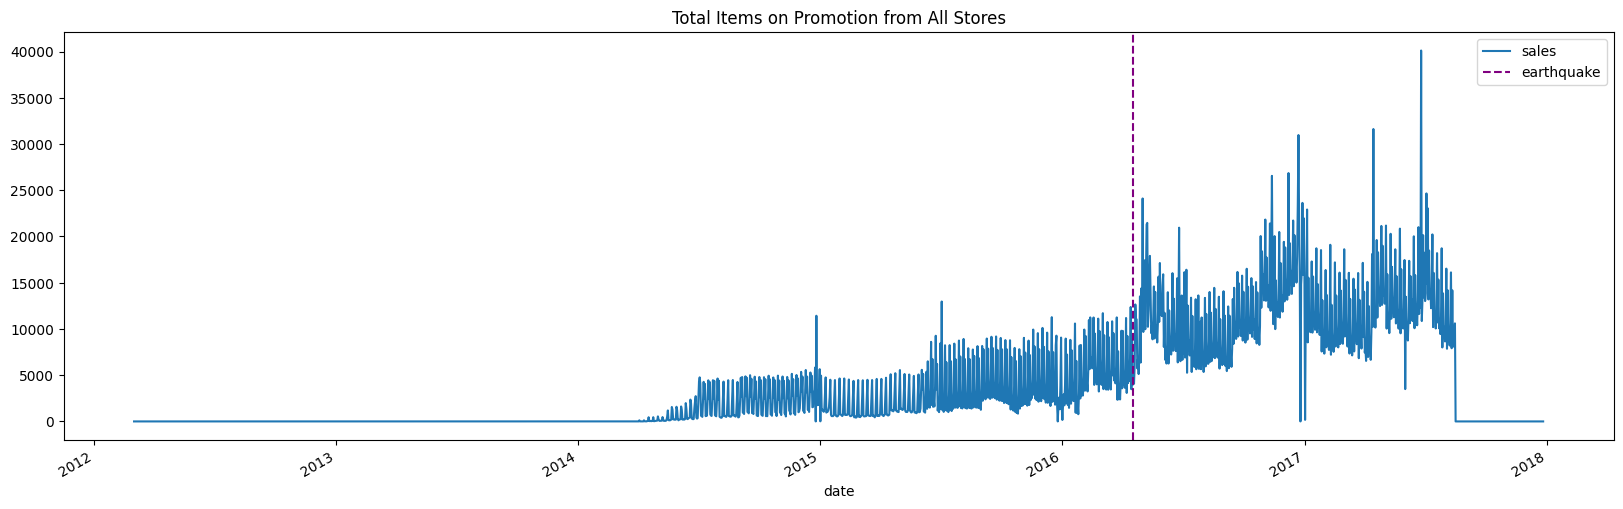

In [23]:
#define earthqueake
earthquake = [pd.to_datetime('2016-04-16')]

ax = merged_data.groupby(['date'], as_index=False)['onpromotion'].sum().plot(
    'date', 'onpromotion', figsize=(20,6), title='Total Items on Promotion from All Stores')
ax.axvline(earthquake, color='purple', linestyle='--')
ax.legend(['sales', 'earthquake']);

we can see that there was a drastic increase in sales immediately after the earthquake which lasted for some weeks

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [24]:
# merge the two datasets on the store_nbr column
merged = pd.merge(stores, transactions, on='store_nbr')

# group the merged dataset by cluster, city, state, and type and calculate the sum of transactions for each group
grouped = merged.groupby(['cluster', 'city', 'state', 'type'])['transactions'].sum()

# print the grouped data
print(grouped)


cluster  city           state                           type
1        Daule          Guayas                          D        2485687
         Guayaquil      Guayas                          D        3568206
         Salinas        Santa Elena                     D        1520362
2        Cuenca         Azuay                           D        3284365
3        El Carmen      Manabi                          C        1451290
         Guayaquil      Guayas                          C        2236356
         Machala        El Oro                          C        2181195
         Playas         Guayas                          C        1123889
         Quevedo        Los Rios                        C        1743003
         Santo Domingo  Santo Domingo de los Tsachilas  C        1464498
4        Loja           Loja                            D        2867052
         Machala        El Oro                          D        1764146
         Santo Domingo  Santo Domingo de los Tsachilas  D      

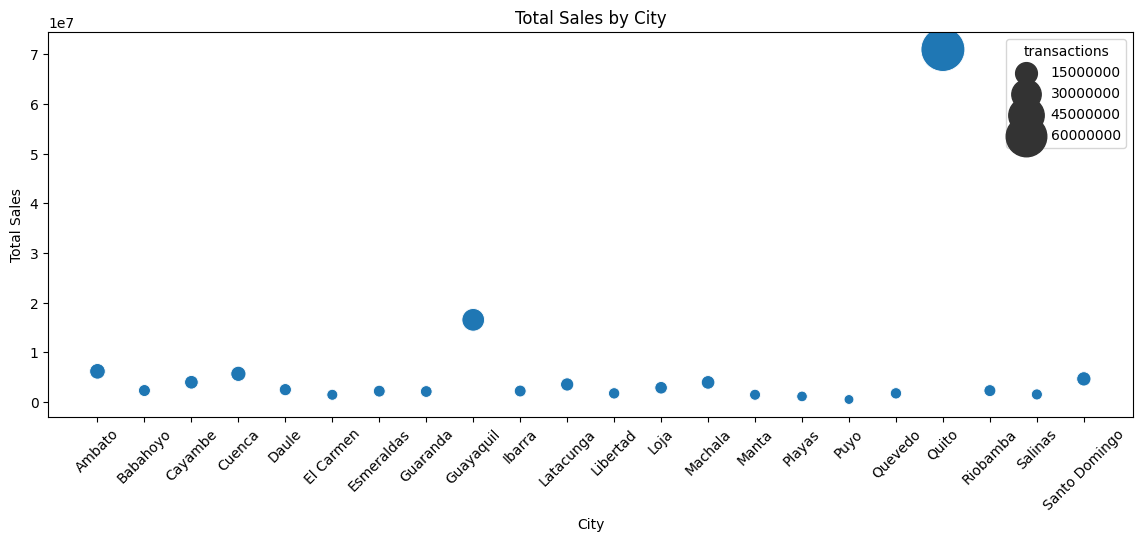

In [25]:
# Aggregate sales data by city
sales_by_city = merged.groupby('city')['transactions'].sum().reset_index()

# Create bubble plot
plt.figure(figsize=(14,5))
sns.scatterplot(x='city', y='transactions', size='transactions', sizes=(50, 1000), data=sales_by_city, palette='Set2')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


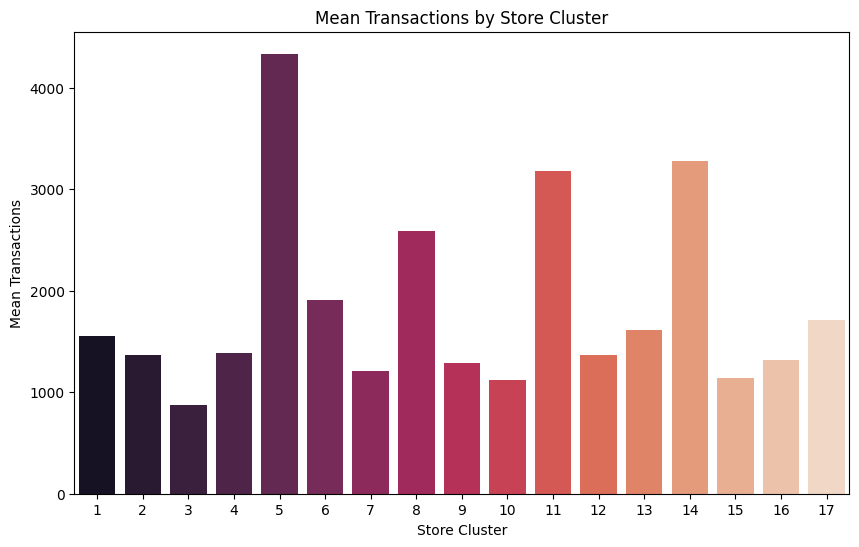

In [26]:
# Group by cluster and calculate the mean transactions
grouped_df = merged.groupby("cluster")["transactions"].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x="cluster", y="transactions", data=grouped_df, palette='rocket')
# Add labels and title
plt.xlabel("Store Cluster")
plt.ylabel("Mean Transactions")
plt.title("Mean Transactions by Store Cluster")
# Show the plot
plt.show()


In [27]:
# Group merged dataset by state and sum transactions
state_transactions = merged.groupby('state')['transactions'].sum()

# Print state_transactions
print(state_transactions)

state
Azuay                              5673847
Bolivar                            2107489
Chimborazo                         2287850
Cotopaxi                           3531356
El Oro                             3945341
Esmeraldas                         2182356
Guayas                            21894000
Imbabura                           2209898
Loja                               2867052
Los Rios                           4049047
Manabi                             2906765
Pastaza                             504156
Pichincha                         74971545
Santa Elena                        1520362
Santo Domingo de los Tsachilas     4655266
Tungurahua                         6172615
Name: transactions, dtype: int64


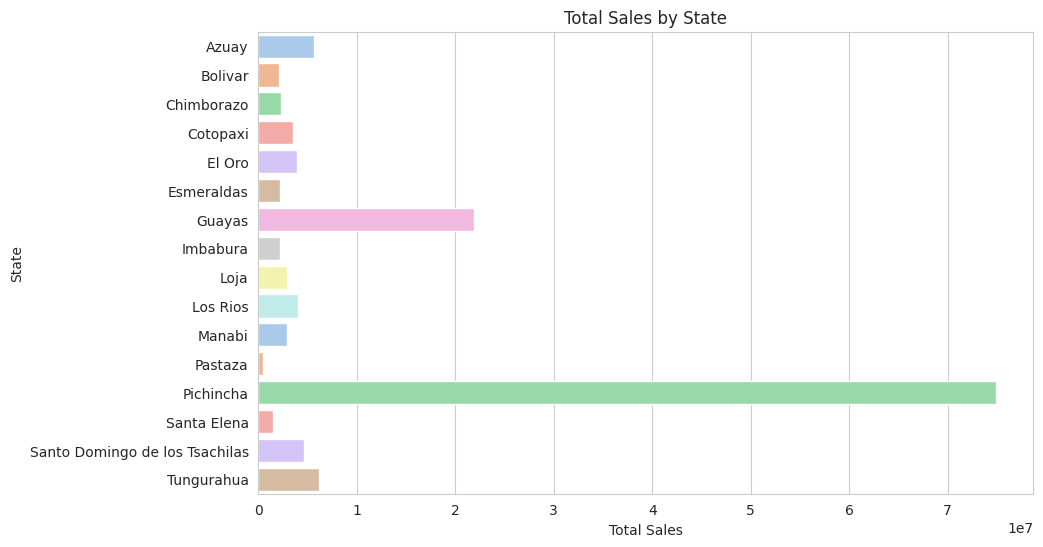

In [28]:
# Group stores by state and calculate total sales
sales_by_state = stores.merge(transactions, on='store_nbr', how='left').groupby('state')['transactions'].sum().reset_index()

# Transpose the sales_by_state dataframe
sales_by_state_transposed = sales_by_state.set_index('state').T

# Create a horizontal bar chart with Seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(data=sales_by_state_transposed, palette='pastel', orient='h')
plt.title('Total Sales by State')
plt.xlabel('Total Sales')
plt.ylabel('State')
plt.show()


In [29]:

# merge the two datasets on store_nbr
merged_df = pd.merge(stores, transactions, on='store_nbr')

# group by store type and sum the transactions for each group
type_transactions = merged.groupby('type')['transactions'].sum()

# print the results
print(type_transactions)


type
A    43215470
B    20384902
C    24788958
D    46230088
E     6859527
Name: transactions, dtype: int64


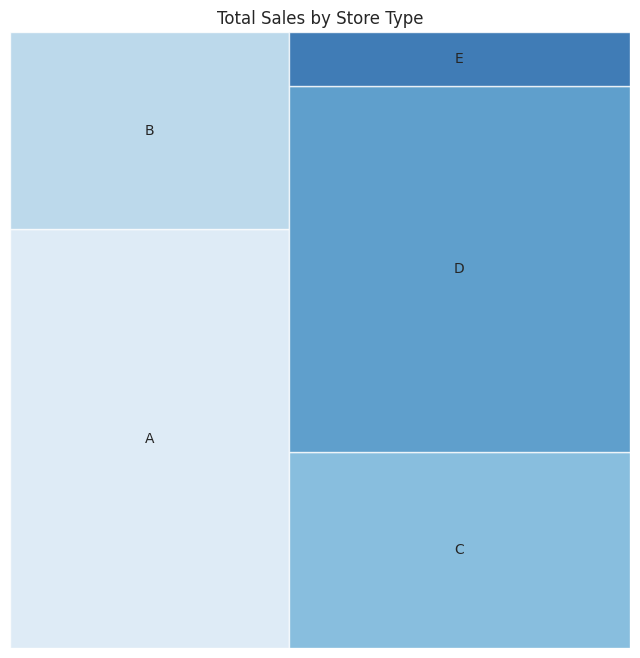

In [30]:

# Group by store type and sum the transactions column
sales_by_type = merged.groupby('type')['transactions'].sum().reset_index()

# Set up the color gradient
colors = sns.color_palette('Blues', len(sales_by_type))
color_map = dict(zip(sales_by_type['type'], colors))

# Create the treemap
fig, ax = plt.subplots(figsize=(8, 8))
squarify.plot(sizes=sales_by_type['transactions'], label=sales_by_type['type'], alpha=0.8, color=[color_map[type] for type in sales_by_type['type']])
plt.axis('off')
plt.title('Total Sales by Store Type')
plt.show()


5. **Are sales affected by promotions, oil prices and holidays?**

In [31]:
# Calculate the correlation between sales and promotions
corr = train["sales"].corr(train["onpromotion"])

# Print the correlation coefficient
print("Correlation coefficient:", corr)

Correlation coefficient: 0.4279232048121313


we can see that there isnt much corellation between these two, lets probe depper by charting this to see:

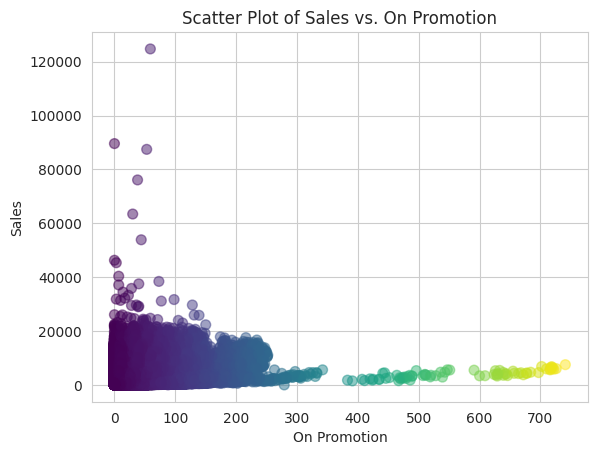

In [32]:
# Create a scatter plot of sales vs. onpromotion
plt.scatter(train["onpromotion"], train["sales"], alpha=0.5, c=train["onpromotion"], cmap="viridis", s=50)

# Add labels and title
plt.xlabel("On Promotion")
plt.ylabel("Sales")
plt.title("Scatter Plot of Sales vs. On Promotion")

# Show the plot
plt.show()

In [33]:
merged_data.sample(2)

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster,year
3000792,2013-04-02,163914.0,9.0,BEVERAGES,1331.0,0.0,2340.0,NaN,NaN,NaN,NaN,NaN,97.23,Quito,Pichincha,B,6.0,2013
2016244,2016-01-02,1948891.0,41.0,EGGS,143.0,0.0,1347.0,NaN,NaN,NaN,NaN,NaN,NaN,Machala,El Oro,D,4.0,2016


# New Feature Creation

In [34]:
#drop unnecessary columns
merged_data = merged_data.drop(columns=['id','locale', 'locale_name', 'description', 'transferred'])

In [35]:
merged_data.head(2)

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,state,store_type,cluster,year
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Holiday,94.756667,Quito,Pichincha,D,13.0,2013
1,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Holiday,94.756667,Quito,Pichincha,D,13.0,2013


In [36]:

# Import necessary libraries
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Encode categorical columns
merged_data['family'] = le.fit_transform(merged_data['family'])
merged_data['city'] = le.fit_transform(merged_data['city'])
merged_data['state'] = le.fit_transform(merged_data['state'])
merged_data['store_type'] = le.fit_transform(merged_data['store_type'])
merged_data['cluster'] = le.fit_transform(merged_data['cluster'])
merged_data['holiday_type'] = le.fit_transform(merged_data['holiday_type'])



In [37]:
from sklearn.preprocessing import StandardScaler

# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['store_nbr','family','sales', 'transactions', 'dcoilwtico','city', 'cluster', 'year']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

In [38]:
merged_data.sample(8)

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,state,store_type,cluster,year
2544156,2017-07-12,-1.443623,0.525044,-0.320623,0.0,-0.459306,6,-0.874054,1.347872,14,3,-0.963828,1.603345
697267,2014-07-08,-0.481208,-0.630154,-0.324235,0.0,NaN,2,1.407757,0.869009,12,1,-0.533713,-0.626061
1493904,2014-11-29,0.352886,1.155152,-0.322429,0.0,-0.442757,6,NaN,0.709388,9,2,-1.178885,-0.626061
1310490,2013-10-13,0.160403,1.155152,-0.324235,0.0,-1.141948,6,NaN,-0.727201,6,2,-1.178885,-1.369197
2978466,2016-01-22,-1.251140,0.209990,-0.058721,0.0,1.111806,6,-1.396401,0.869009,12,3,-0.103599,0.860210
2168494,2014-07-26,1.058657,1.575224,-0.316107,0.0,3.153526,6,NaN,0.869009,12,0,-0.748771,-0.626061
2831895,2013-04-26,-1.379462,-1.680335,-0.323332,0.0,-0.091093,6,0.962535,0.869009,12,3,0.971687,-1.369197
1642924,2013-03-21,0.545369,0.315008,-0.324235,0.0,NaN,6,0.955913,-0.248338,6,4,0.326515,-1.369197


In [39]:
merged_data.dropna(subset=['sales'], inplace=True)

In [40]:
merged_data.head(2)

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,state,store_type,cluster,year
0,2013-01-01,-1.700267,-1.680335,-0.324235,0.0,NaN,3,1.045373,0.869009,12,3,0.971687,-1.369197
1,2013-01-01,-1.700267,-1.575317,-0.324235,0.0,NaN,3,1.045373,0.869009,12,3,0.971687,-1.369197


In [41]:
# drop columns
merged_data = merged_data.drop(columns=['state','date'])

In [42]:
merged_data

,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,store_type,cluster,year
0,-1.700267,-1.680335,-0.324235,0.0,NaN,3,1.045373,0.869009,3,0.971687,-1.369197
1,-1.700267,-1.575317,-0.324235,0.0,NaN,3,1.045373,0.869009,3,0.971687,-1.369197
2,-1.700267,-1.470299,-0.324235,0.0,NaN,3,1.045373,0.869009,3,0.971687,-1.369197
3,-1.700267,-1.365281,-0.324235,0.0,NaN,3,1.045373,0.869009,3,0.971687,-1.369197
4,-1.700267,-1.260263,-0.324235,0.0,NaN,3,1.045373,0.869009,3,0.971687,-1.369197
...,...,...,...,...,...,...,...,...,...,...,...
3054343,-1.186979,1.260170,0.071447,0.0,0.473638,3,-0.792644,0.869009,1,-0.533713,1.603345
3054344,-1.186979,1.365188,-0.184657,1.0,0.473638,3,-0.792644,0.869009,1,-0.533713,1.603345
3054345,-1.186979,1.470206,1.861045,148.0,0.473638,3,-0.792644,0.869009,1,-0.533713,1.603345
3054346,-1.186979,1.575224,-0.214959,8.0,0.473638,3,-0.792644,0.869009,1,-0.533713,1.603345


## Spliting the Dataset

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# convert datetime column to Unix timestamp format
#merged_data['date'] = pd.to_datetime(merged_data['date'])
#merged_data['date'] = (merged_data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_data.drop('sales', axis=1), merged_data['sales'], test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='mean')

# impute the missing values in your data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model on the test set
score = model.score(X_test, y_test)
print(f'R-squared score: {score:.2f}')


R-squared score: 0.24


In [44]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='mean')

# impute the missing values in your data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#**Machine Learning Modeling**

## Linear Regression Model

In [45]:
from sklearn.metrics import mean_squared_error

# predict on test set
y_pred = model.predict(X_test)

# calculate MSE
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.76


In [46]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make prediction on X_test
lr_predictions = lr.predict(X_test)

In [47]:
# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)

# Print the evaluation results for Linear Regression model
print("\nEvaluation Results for Linear Regression:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("RMSLE:", lr_rmsle)


Evaluation Results for Linear Regression:
MSE: 0.76
RMSE: 0.87
RMSLE: 0.3


## Decision Tree Regression Model

In [48]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Make prediction on X_test
dt_predictions = dt.predict(X_test)

# Evaluation Metrics for Decision Tree Regression
dt_mse = mean_squared_error(y_test, dt_predictions).round(2)
dt_rmse = np.sqrt(dt_mse).round(2)

# Evaluation Metrics for Decision Tree Regression
dt_predictions_abs = abs(dt_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and dt_predictions_abs array
dt_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, dt_predictions_abs)).round(2)

# Print the evaluation results for Decision Tree Regression model
print("\nEvaluation Results for Decision Tree Regression:")
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)

print("RMLSE:", dt_rmsle)


Evaluation Results for Decision Tree Regression:
MSE: 0.12
RMSE: 0.35
RMLSE: 0.08


## XGBoost Model

In [49]:
# import the XGBoost library
import xgboost as xgb

# create an instance of the XGBRegressor class
xgb_model = xgb.XGBRegressor()

# fit the model on the training data
xgb_model.fit(X_train, y_train)

# make predictions on the test data
xgb_predictions = xgb_model.predict(X_test)


In [50]:
# Evaluation Metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_predictions).round(2)
xgb_rmse = np.sqrt(xgb_mse).round(2)

#y_test_abs = abs(y_test)
xgb_predictions_abs = abs(xgb_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and xgb_predictions_abs array
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, xgb_predictions_abs)).round(2)

# Print the evaluation results for XGBoost model
print("\nEvaluation Results for XGBoost:")
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("RMSLE:", xgb_rmsle)


Evaluation Results for XGBoost:
MSE: 0.08
RMSE: 0.28
RMSLE: 0.09


## Random Forest Regression Model

In [51]:
# Random Forest Regression Model
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)

# Make prediction on X_test
rf_predictions = rf.predict(X_test)

In [52]:
# Evaluation Metrics for Random Forest Regression
rf_mse = mean_squared_error(y_test, rf_predictions).round(2)
rf_rmse = np.sqrt(rf_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
rf_predictions_abs = abs(rf_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and rf_predictions_abs array
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, rf_predictions_abs)).round(2)

# Print the evaluation results for Random Forest Regrression model
print("\nEvaluation Results for Random Forest:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("RMSLE:", rf_rmsle)
                                          


Evaluation Results for Random Forest:
MSE: 0.06
RMSE: 0.24
RMSLE: 0.07


In [53]:
# Define a table to compare evaluation results
evaluation_metrics = ['MSE', 'RMSE', 'RMSLE']
models = ['Linear Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = [[lr_mse, lr_rmse, lr_rmsle],
           [dt_mse, dt_rmse, dt_rmsle],
           [xgb_mse, xgb_rmse, xgb_rmsle],
           [rf_mse, rf_rmse, rf_rmsle]]
results_table = pd.DataFrame(data=results, columns=evaluation_metrics, index=models)

# Print the comparison table
print("Comparison Table of Evaluation Results:\n", results_table)


Comparison Table of Evaluation Results:
                     MSE  RMSE  RMSLE
Linear Regression  0.76  0.87   0.30
Decision Tree      0.12  0.35   0.08
XGBoost            0.08  0.28   0.09
Random Forest      0.06  0.24   0.07
